In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

In [2]:
# Loading
file = '../fakedata.csv' # Update later
df = pd.read_csv(file)
df = df[['Time Period','UserID','Date','Value 1']]
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [3]:
# Identify Time A and Time B
time_a_df = df[df['Time Period'] == 'Time A']
time_b_df = df[df['Time Period'] == 'Time B']

# Split Time A into 80% training and 20% testing
total_time_a = len(time_a_df)
train_size = int(0.8 * total_time_a)
train_df = time_a_df.iloc[:train_size]
test_df = time_a_df.iloc[train_size:]

train_observations = train_df['Value 1'].values
test_observations = test_df['Value 1'].values
test_dates = test_df['Date']


In [4]:
# Train Kalman Filter on 80% of Time A
kf = KalmanFilter(initial_state_mean=train_observations[0], 
                  n_dim_obs=1, 
                  transition_matrices=[1], 
                  observation_matrices=[1], 
                  initial_state_covariance=1, 
                  transition_covariance=0.01, 
                  observation_covariance=1)

state_means, state_covariances = kf.filter(train_observations.reshape(-1, 1))

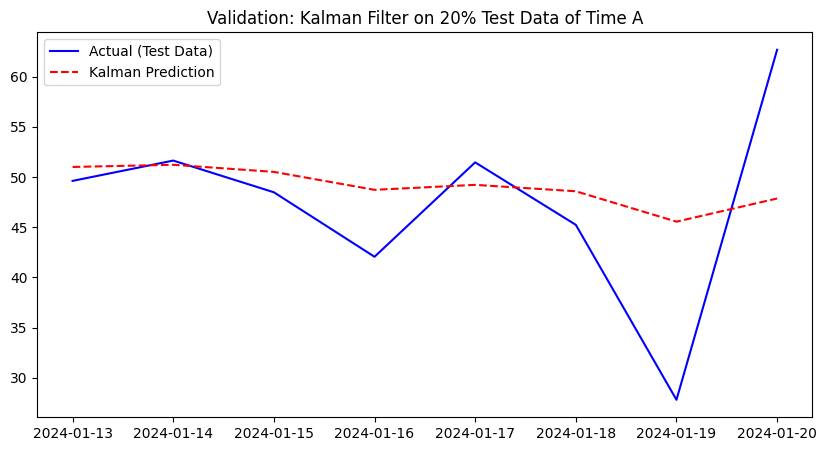

In [5]:
# Validate on 20% of Time A
test_filtered_means, _ = kf.filter(test_observations.reshape(-1, 1))

# Compute residuals for test set
test_residuals = test_observations - test_filtered_means.flatten()

# Plot results for validation
plt.figure(figsize=(10, 5))
plt.plot(test_dates, test_observations, label="Actual (Test Data)", color="blue")
plt.plot(test_dates, test_filtered_means, label="Kalman Prediction", color="red", linestyle="dashed")
plt.legend()
plt.title("Validation: Kalman Filter on 20% Test Data of Time A")
plt.show()

In [6]:
# Retrain using ALL of Time A
all_time_a_observations = time_a_df['Value 1'].values
kf = KalmanFilter(initial_state_mean=all_time_a_observations[0], 
                  n_dim_obs=1, 
                  transition_matrices=[1], 
                  observation_matrices=[1], 
                  initial_state_covariance=1, 
                  transition_covariance=0.01, 
                  observation_covariance=1)

state_means_full, state_covariances_full = kf.filter(all_time_a_observations.reshape(-1, 1))


In [7]:
# Apply to Time A and B
all_time_a_b_observations = np.concatenate([all_time_a_observations, time_b_df['Value 1'].values])
full_filtered_means, _ = kf.filter(all_time_a_b_observations.reshape(-1, 1))


# Compute residuals to detect drift
residuals = all_time_a_b_observations - full_filtered_means.flatten()


In [8]:
# Drift threshold
baseline_residuals = residuals[:len(all_time_a_observations)]  # Residuals from Time A only
threshold = np.mean(baseline_residuals) + 2 * np.std(baseline_residuals)


# Identify drift points in Time B
drift_points = np.where(residuals[len(all_time_a_observations):] > threshold)[0]
drift_dates = time_b_df.iloc[drift_points]['Date']

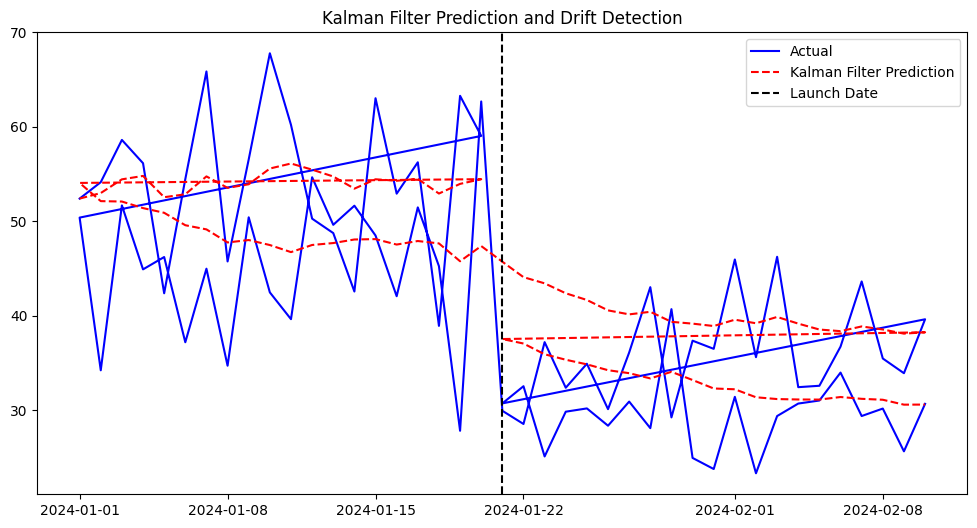

In [9]:
# Visualization
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Value 1'], label="Actual", color="blue")
plt.plot(df['Date'], full_filtered_means, label="Kalman Filter Prediction", color="red", linestyle="dashed")
plt.axvline(x=time_b_df['Date'].iloc[0], color="black", linestyle="--", label="Launch Date")

# Highlight drift points
if len(drift_dates) > 0:
    plt.scatter(drift_dates, time_b_df.iloc[drift_points]['Value 1'], color="orange", label="Detected Drift", zorder=3)

plt.legend()
plt.title("Kalman Filter Prediction and Drift Detection")
plt.show()